In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# install the clean-text library
!pip install clean-text

# install the praw library
!pip install praw

# install the spacy library
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

# install pyldavis for interactive topic model visualization
!pip install pyldavis

%matplotlib notebook
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 175 kB 35.6 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=83430a5928dddefa25bd9c09293b24e3c9e25ef17f5695d5d11a511b49026240
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 32.8 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-12-03 02:02:00.695476: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi

In [ ]:
import re
import string
import html
import nltk
import spacy
import praw 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cleantext import clean
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords') 
nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_sm")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from PIL import Image
import requests
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


# Important Notes

**Imported Original Datasets**
- The provided Twitter dataset for Part 1: ***sentiment_analysis.csv***
- The Russia-Ukraine-War related Tweets retrieved from: 

  https://omkargawade.medium.com/russia-ukraine-war-tweets-nlp-analysis-bd10b352316c

<br/>

***UkraineCombinedTweetsDeduped.csv***
- The scraped Reddit comments about Russia-Ukraine-War: **reddit_comments.csv**

<br/>

**Imported Processed Datasets**

The imported datasets are cleaned accordingly in this notebook. However, since the text cleaning processes are very time-consuming, the codes for text cleaning are commented out, and the following CSV files containing the cleaned text are read into the notebook instead:
- The cleaned text for Part 1 model development: ***p1_text_cleaned.csv***
- The cleaned text for Part 2 Tweets Analysis: ***p2_data_tweet_text_cleaned.csv***
- The cleaned text for Part 2 Reddit Analysis: ***p2_data_reddit_text_cleaned.csv***

<br/>

**All import CSVs can be downloaded from Google Drive:**

https://drive.google.com/drive/folders/1Ugdfx1FkHCJ7m8n1_MfiVbqLK7ysoIZu?usp=sharing

<br/>

**Hyperparameter Tuning and Cross-validation**

The tuning and CV processes are extremely time-consuming; thus, the CV-related codes were commented out after tuning the hyperparameters.

# 1.0 Sentiment Modeling

In [ ]:
# read data
p1_data = pd.read_csv('sentiment_analysis.csv')
p1_data.head()

ID                                               text  label
0  7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1  7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2  7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3  7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4  7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1

In [ ]:
# Check data balance 
p1_data['label'].value_counts()

1    371341
0    179050
Name: label, dtype: int64

In [ ]:
# Undersample class 1
postive_df = p1_data[p1_data['label']==1]
negative_df = p1_data[p1_data['label']==0]
postive_undersample_df = postive_df.sample(n=179050,random_state = 0)
balanced_data = pd.concat([postive_undersample_df, negative_df], ignore_index=True)
balanced_data = balanced_data.sample(frac=1)
balanced_data['label'].value_counts()

1    179050
0    179050
Name: label, dtype: int64

In [ ]:
balanced_data

ID                                               text  label
36648   8.036590e+17  #Homeopathy - A Healthy #Alternative to prescr...      1
269775  8.003090e+17  De Lima’s prediction: Kerwin, Jaybee will get ...      0
221400  7.964720e+17  "Suck my sexy Shemale cock as I workout!" http...      0
127540  7.809690e+17  Visit Haissa's profile on Punter Planet. Proud...      1
138773  7.988480e+17  We can’t wait to see you for #SundaysAtC7 with...      1
...              ...                                                ...    ...
113094  7.821270e+17  Have a good weekend, but if you need #GP advic...      1
175815  7.981950e+17  170 Fantastic Small Living Room Interior Ideas...      1
115362  7.692730e+17  Looking fantastic in their first outing in the...      1
264232  7.998230e+17  Are you making this harmful real estate SEO mi...      0
92131   7.695080e+17  RT @BSNLCorporate: 3 Exciting reasons to get a...      1

[358100 rows x 3 columns]

## 1.1 Text Cleaning

In [ ]:
def remove_stopword(text):
    stop_words = set(stopwords.words("english"))
    stop_words.add('rt')
    stop_words.add('im')
    stop_words.add('iam')
    stop_words.add('int')
    
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
def clean_text(text):
    return clean(
        text,
        fix_unicode=True,
        to_ascii=True,
        lower=True,
        normalize_whitespace=True,
        no_line_breaks=False,
        strip_lines=True,
        keep_two_line_breaks=False,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=True,
        no_digits=True,
        no_currency_symbols=True,
        no_punct=True,
        no_emoji=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        replace_with_punct="",
        lang="en")

In [ ]:
def remove_urls(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.(\w+)", "", text)
    return text

In [ ]:
def strip_all_tags(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [ ]:
#lemmatize words
def lemmatize_text(text):
    tokens = []
    for t in nlp(text):
        tokens.append(t.lemma_)
    return ' '.join(tokens)

Tweets Cleaning Procedure:
- 1. Remove html tags
- 2. Remove hashtags and user tags 
- 3. Lower case all the strings
- 4. Remove all the stopwords
- 5. Utilize the 'clean-text' library to remove all the digits, numbers, emoji, punct, etc.
- 6. Lemmatization
- 7. Remove all the stopwords again in case any were returned during step 5 or 6

In [ ]:
# Clean the tweets sequentially
# balanced_data['cleaned_text'] = balanced_data['text'].apply(remove_urls).apply(strip_all_tags).apply(lambda x: x.lower()).apply(clean_text).apply(remove_stopword).apply(lemmatize_text).apply(remove_stopword)

In [ ]:
# Save the cleaned tweets as csv
# balanced_data[['cleaned_text','label']].to_csv('p1_text_cleaned.csv', index = None, header=True)

## 1.2 Feature Engineering - TF-IDF

In [ ]:
# Load processed data
senti_cleaned = pd.read_csv('p1_text_cleaned.csv')

In [ ]:
# Drop rows that contain NaN
senti_cleaned.dropna(inplace=True)
senti_cleaned

cleaned_text  label
0                             good national park see list      1
1                                              oh shit tf      0
2                        holy shit like give orgasm right      0
3                                           work ass boii      0
4       incredible turnout tonight event heartland church      1
...                                                   ...    ...
358095  thank stand old brother really treat real sibl...      1
358096                                good lady ever meet      1
358097                                         ship bitch      0
358098  happy birthday sebastian still remember time h...      1
358099   love smol cutie pie much believe get old believe      1

[357744 rows x 2 columns]

In [ ]:
# train-test split (7/3)
X_senti = senti_cleaned['cleaned_text'].to_list()
y_senti = senti_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X_senti, y_senti, random_state=0, test_size=0.3)

In [ ]:
# apply tf-idf and get the top 500 features
tfidf = TfidfVectorizer(lowercase=True, max_features = 500)
X_train_idf = tfidf.fit_transform(X_train) # only fit the training data    
X_test_idf = tfidf.transform(X_test)

In [ ]:
X_train_idf = pd.DataFrame(X_train_idf.todense(), columns = tfidf.get_feature_names_out())
X_test_idf = pd.DataFrame(X_test_idf.todense(), columns = tfidf.get_feature_names_out())

In [ ]:
X_train_idf.head(5)

abuse  account  act  actually  add   af  ago  almost  already  also  ...  \
0    0.0      0.0  0.0       0.0  0.0  0.0  0.0     0.0      0.0   0.0  ...   
1    0.0      0.0  0.0       0.0  0.0  0.0  0.0     0.0      0.0   0.0  ...   
2    0.0      0.0  0.0       0.0  0.0  0.0  0.0     0.0      0.0   0.0  ...   
3    0.0      0.0  0.0       0.0  0.0  0.0  0.0     0.0      0.0   0.0  ...   
4    0.0      0.0  0.0       0.0  0.0  0.0  0.0     0.0      0.0   0.0  ...   

   write  wrong  wtf   ya  yeah  year  yes  yesterday  yet  young  
0    0.0    0.0  0.0  0.0   0.0   0.0  0.0        0.0  0.0    0.0  
1    0.0    0.0  0.0  0.0   0.0   0.0  0.0        0.0  0.0    0.0  
2    0.0    0.0  0.0  0.0   0.0   0.0  0.0        0.0  0.0    0.0  
3    0.0    0.0  0.0  0.0   0.0   0.0  0.0        0.0  0.0    0.0  
4    0.0    0.0  0.0  0.0   0.0   0.0  0.0        0.0  0.0    0.0  

[5 rows x 500 columns]

In [ ]:
X_train_idf.shape, X_test_idf.shape

((250420, 500), (107324, 500))

## 1.3 Train Four Classification Algorithms

### 1.3.0 Functions for Metrics and Plots

In [ ]:
def cm_scores(y_test, y_test_predicted, dataset):
    # Different Metrics
    acc = accuracy_score(y_test, y_test_predicted)
    f1 = f1_score(y_test, y_test_predicted)
    auc = roc_auc_score(y_test, y_test_predicted)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_predicted)
    precision = cm[1,1]/cm.sum(axis=0)[1]
    recall = cm[1,1]/cm.sum(axis=1)[1]
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Negative','Positive']
    plt.title(dataset + '\n' + 'Precision: %s'%round(precision,3) + ' ' + 'Recall: %s'%round(recall,3))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=0)
    plt.yticks(tick_marks, classNames, rotation=90)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return [acc, precision, recall, f1, auc]

In [ ]:
def ROC_plot(train_prob, test_prob, y_train, y_test):
    # Scores for train set
    scores_train = train_prob[:, 1]
    # Scores for test set
    scores_test = test_prob[:, 1]
    # ROC Calc Train set
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    # ROC Calc Test set
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    # AUC Calc
    auc_train = auc(fpr_train, tpr_train)
    # AUC Calc
    auc_test  = auc(fpr_test, tpr_test)

    # Plotting
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title('ROC curves', fontsize = 18)
    plt.ylabel('True positive rate', fontsize = 18)
    plt.xlabel('False positive rate', fontsize = 18)
    plt.legend()

### 1.3.1 Logistic Regression

#### Model Tuning using Grid Search with CV

In [ ]:
## After runing once, the CV is commented out due to lengthy execution time
# logit = LogisticRegression(penalty ='l1', solver = 'liblinear', random_state = 1)
# grid = {'C':[0.001,0.01,0.1,1,10,100]}
# logit_cv = GridSearchCV(logit, grid, scoring='f1', cv=5, n_jobs=-1)
# logit_cv.fit(X_train_idf, y_train)
# best_hyper = logit_cv.best_params_
# print ("Best f1: {}".format(logit_cv.best_score_))      
# print('The best parameter:', best_hyper)

Best f1: 0.9167509918973014
The best parameter: {'C': 1}


The best C was found to be 1 with a CV f1 score of 0.9167509918973014

#### Model Implementation

In [ ]:
# fit model on the train
tuned_model_logit = LogisticRegression(C=1, penalty ='l1', solver = 'liblinear', random_state= 1)
tuned_model_logit.fit(X_train_idf, y_train)
y_train_pred_logit = tuned_model_logit.predict(X_train_idf)
y_train_prob_logit = tuned_model_logit.predict_proba(X_train_idf)
y_test_pred_logit = tuned_model_logit.predict(X_test_idf)
y_test_prob_logit = tuned_model_logit.predict_proba(X_test_idf)

#### Model Testing

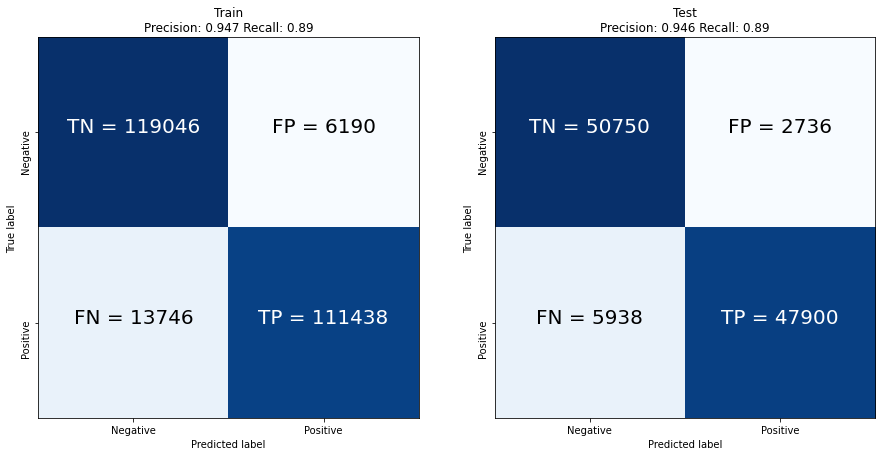

In [ ]:
plt.subplots(figsize=(15, 15))
plt.subplot(1,2,1)
train_scores_logit = cm_scores(y_train, y_train_pred_logit, 'Train')

plt.subplot(1,2,2)
test_scores_logit = cm_scores(y_test, y_test_pred_logit, 'Test')

In [ ]:
scores_logit = pd.DataFrame(train_scores_logit, index = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], columns = ['Train'])
scores_logit['Test'] = test_scores_logit
scores_logit.T

Accuracy  Precision    Recall        F1   ROC_AUC
Train  0.920390   0.947376  0.890194  0.917895  0.920383
Test   0.919179   0.945967  0.889706  0.916975  0.919276

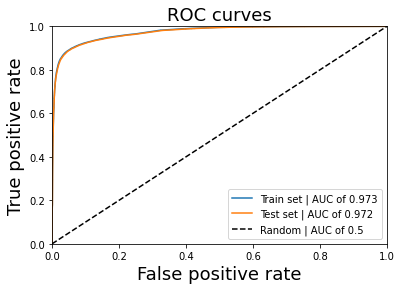

In [ ]:
ROC_plot(y_train_prob_logit, y_test_prob_logit, y_train, y_test)

### 1.3.2 Decision Tree

#### Model Tuning using Grid Search with CV

In [ ]:
def tree_CV(X_train, y_train): 
    mean_CV_score = []
    max_depth_log = []
    min_samples_split_log = []
    for maxDepth in np.arange(10, 50, 10):
        for minSamplesSplit in np.arange(2, 8, 2):
            dt_nested = tree.DecisionTreeClassifier(max_depth = maxDepth, min_samples_split = minSamplesSplit, random_state = 0)
            dt_scores_1 = cross_validate(dt_nested, X_train, y_train, cv=5, scoring = 'f1', n_jobs = -1)
            mean_CV_score.append(dt_scores_1['test_score'].mean())
            max_depth_log.append(maxDepth)
            min_samples_split_log.append(minSamplesSplit)
    best_DT_index = np.array(mean_CV_score).argmax()
    print("Among all the Decision Tree Classifier runs, the best mean CV 'f1' score is", round(mean_CV_score[best_DT_index],4), "with a max_depth of", max_depth_log[best_DT_index], "and a min_samples_split of", min_samples_split_log[best_DT_index])

In [ ]:
# After runing once, the CV was commented out due to long execution time
# tree_CV(X_train_idf, y_train)

Among all the Decision Tree Classifier runs, the best mean CV 'f1' score is 0.8952 with a max_depth of 40 and a min_samples_split of 2


In [ ]:
print("Among all the Decision Tree Classifier runs, the best mean CV 'f1' score is 0.8952 with a max_depth of 40 and a min_samples_split of 2")

Among all the Decision Tree Classifier runs, the best mean CV 'f1' score is 0.8952 with a max_depth of 40 and a min_samples_split of 2


#### Model Implementation

In [ ]:
tuned_model_tree = tree.DecisionTreeClassifier(max_depth = 40, min_samples_split = 2)
tuned_model_tree.fit(X_train_idf, y_train)
y_train_pred_tree = tuned_model_tree.predict(X_train_idf)
y_train_prob_tree = tuned_model_tree.predict_proba(X_train_idf)
y_test_pred_tree = tuned_model_tree.predict(X_test_idf)
y_test_prob_tree = tuned_model_tree.predict_proba(X_test_idf)

#### Model Testing

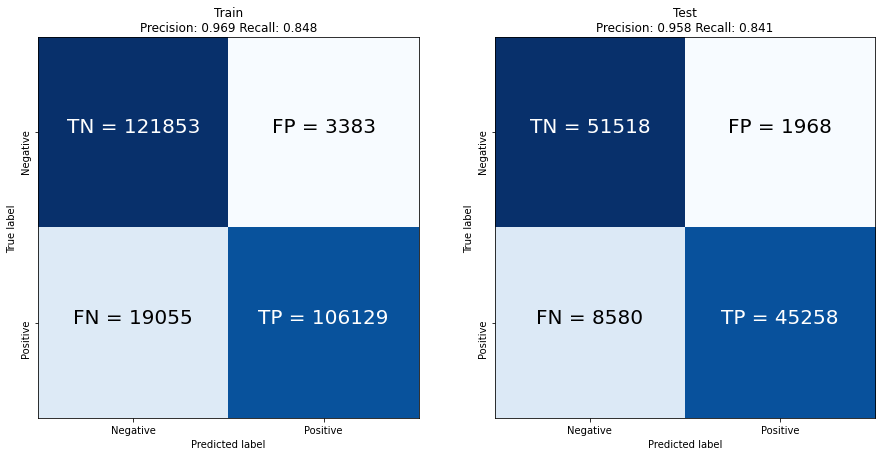

In [ ]:
plt.subplots(figsize=(15, 15))
plt.subplot(1,2,1)
train_scores_tree = cm_scores(y_train, y_train_pred_tree, 'Train')

plt.subplot(1,2,2)
test_scores_tree = cm_scores(y_test, y_test_pred_tree, 'Test')

In [ ]:
scores_tree = pd.DataFrame(train_scores_tree, index = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], columns = ['Train'])
scores_tree['Test'] = test_scores_tree
scores_tree.T

Accuracy  Precision    Recall        F1   ROC_AUC
Train  0.910399   0.969108  0.847784  0.904395  0.910386
Test   0.901718   0.958328  0.840633  0.895630  0.901919

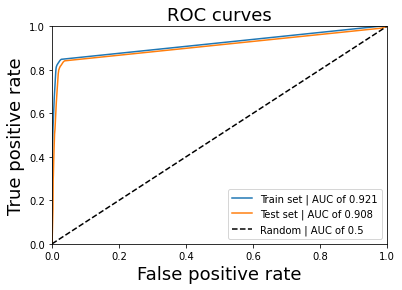

In [ ]:
ROC_plot(y_train_prob_tree, y_test_prob_tree, y_train, y_test)

### 1.3.3 Random Forest

#### Model Tuning using Grid Search with CV

In [ ]:
def RF_CV(X_train, y_train): 
    mean_CV_score = []
    max_depth_log = []
    min_samples_split_log = []
    for maxDepth in np.arange(10, 50, 10):
        for minSamplesSplit in np.arange(2, 8, 2):
            RF_nested = RandomForestClassifier(n_estimators = 100, max_depth = maxDepth, min_samples_split = minSamplesSplit, n_jobs = -1, random_state = 0)
            RF_scores_1 = cross_validate(RF_nested, X_train, y_train, cv=5, scoring = 'f1', n_jobs = -1)
            mean_CV_score.append(RF_scores_1['test_score'].mean())
            max_depth_log.append(maxDepth)
            min_samples_split_log.append(minSamplesSplit)
    best_DT_index = np.array(mean_CV_score).argmax()
    print("Among all the Random Forest Classifier runs, the best mean CV 'f1' score is", round(mean_CV_score[best_DT_index],4), "with a max_depth of", max_depth_log[best_DT_index], "and a min_samples_split of", min_samples_split_log[best_DT_index])

In [ ]:
# After runing once, the CV is commented out due to lengthy execution time
# RF_CV(X_train_idf, y_train)

Among all the Random Forest Classifier runs, the best mean CV 'f1' score is 0.8913 with a max_depth of 40 and a min_samples_split of 2


In [ ]:
print('Among all the Random Forest Classifier runs, the best mean CV f1 score is 0.8913 with a max_depth of 40 and a min_samples_split of 2')

Among all the Random Forest Classifier runs, the best mean CV f1 score is 0.8913 with a max_depth of 40 and a min_samples_split of 2


#### Model Implementation

In [ ]:
# fit model on the train
tuned_model_RF = RandomForestClassifier(n_estimators = 100, max_depth = 40, min_samples_split = 2, n_jobs = -1, random_state = 0)
tuned_model_RF.fit(X_train_idf, y_train)
y_train_pred_RF = tuned_model_RF.predict(X_train_idf)
y_train_prob_RF = tuned_model_RF.predict_proba(X_train_idf)
y_test_pred_RF = tuned_model_RF.predict(X_test_idf)
y_test_prob_RF = tuned_model_RF.predict_proba(X_test_idf)

#### Model Testing

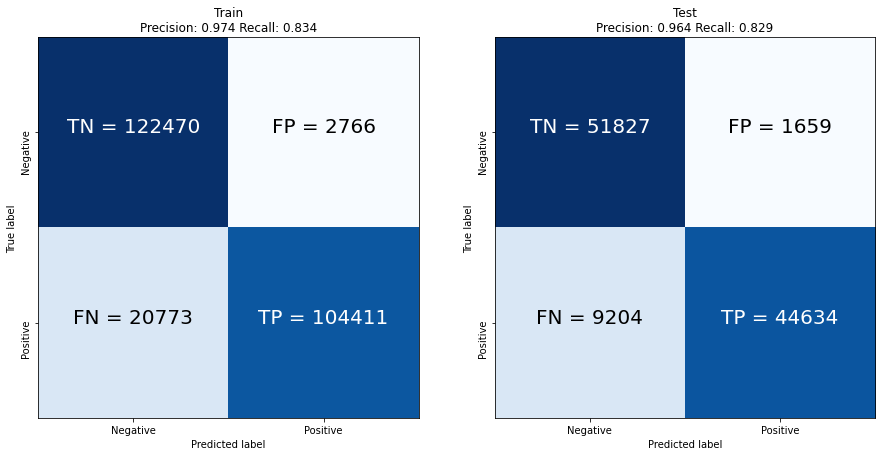

In [ ]:
plt.subplots(figsize=(15, 15))
plt.subplot(1,2,1)
train_scores_RF = cm_scores(y_train, y_train_pred_RF, 'Train')

plt.subplot(1,2,2)
test_scores_RF = cm_scores(y_test, y_test_pred_RF, 'Test')

In [ ]:
scores_RF = pd.DataFrame(train_scores_RF, index = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], columns = ['Train'])
scores_RF['Test'] = test_scores_RF
scores_RF.T

Accuracy  Precision    Recall        F1   ROC_AUC
Train  0.906002   0.974192  0.834060  0.898696  0.905987
Test   0.898783   0.964163  0.829043  0.891512  0.899013

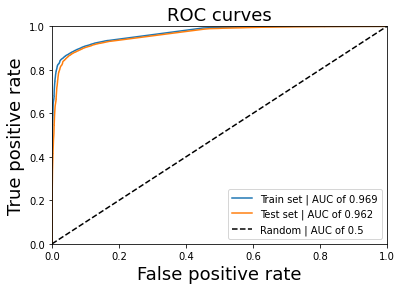

In [ ]:
ROC_plot(y_train_prob_RF, y_test_prob_RF, y_train, y_test)

### 1.3.4 Gaussian Naive Bayes

#### Model Tuning using Grid Search with CV

In [ ]:
def NB_CV(X_train, y_train):
    nb_classifier = GaussianNB()
    params_NB = {'var_smoothing': np.logspace(-8,-12, num=5)}
    gs_NB = GridSearchCV(nb_classifier, params_NB, scoring='f1', cv=5, n_jobs=-1)
    gs_NB.fit(X_train_idf, y_train)
    print('The best hyperparameter is:', gs_NB.best_params_)

In [ ]:
# After runing once, the CV is commented out due to lengthy execution time
# NB_CV(X_train_idf, y_train)

The best hyperparameter is: {'var_smoothing': 1e-10}


#### Model Implementation

In [ ]:
# fit model on the train
tuned_model_NB = GaussianNB(var_smoothing = 1e-10)
tuned_model_NB.fit(X_train_idf, y_train)
y_train_pred_NB = tuned_model_NB.predict(X_train_idf)
y_train_prob_NB = tuned_model_NB.predict_proba(X_train_idf)
y_test_pred_NB = tuned_model_NB.predict(X_test_idf)
y_test_prob_NB = tuned_model_NB.predict_proba(X_test_idf)

#### Model Testing

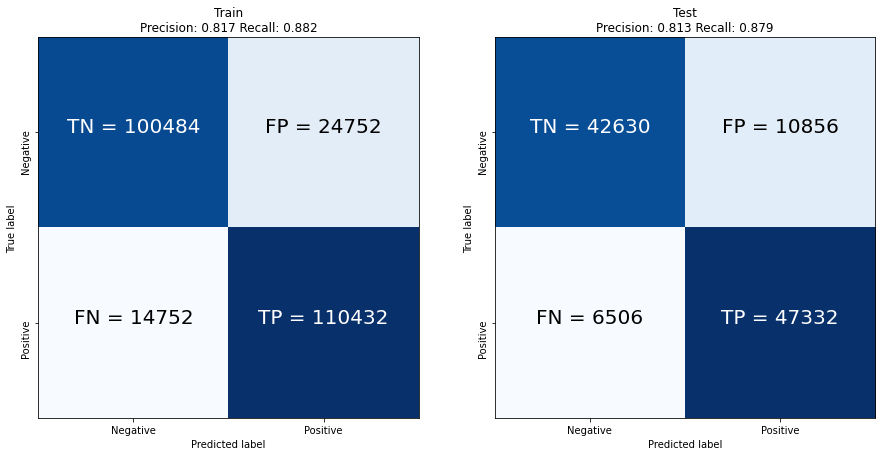

In [ ]:
plt.subplots(figsize=(15, 15))
plt.subplot(1,2,1)
train_scores_NB = cm_scores(y_train, y_train_pred_NB, 'Train')

plt.subplot(1,2,2)
test_scores_NB = cm_scores(y_test, y_test_pred_NB, 'Test')

In [ ]:
scores_NB = pd.DataFrame(train_scores_NB, index = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], columns = ['Train'])
scores_NB['Test'] = test_scores_NB
scores_NB.T

Accuracy  Precision    Recall        F1   ROC_AUC
Train  0.842249   0.816901  0.882157  0.848276  0.842257
Test   0.838228   0.813432  0.879156  0.845018  0.838093

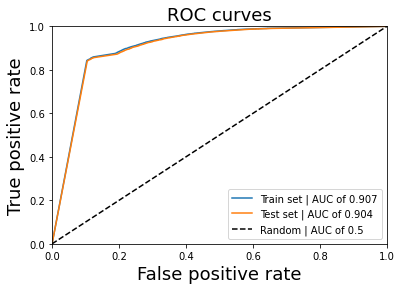

In [ ]:
ROC_plot(y_train_prob_NB, y_test_prob_NB, y_train, y_test)

### 1.4 Model Comparison and Selection

In [ ]:
df_list = [scores_logit, scores_tree, scores_RF, scores_NB]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gaussian Naive Bayes']

In [ ]:
def model_results(df_list, model_names):
    for i, j in zip(df_list, model_names):
        i.columns = pd.MultiIndex.from_product([i.columns, [j]])
    df_model_results = pd.concat(df_list, axis=1).swaplevel(i=0, j=1, axis=1)
    return df_model_results

In [ ]:
Part_1_results = model_results(df_list, model_names).round(2)

In [ ]:
Part_1_results

Logistic Regression       Decision Tree       Random Forest        \
                        Train  Test         Train  Test         Train  Test   
Accuracy                 0.92  0.92          0.91  0.90          0.91  0.90   
Precision                0.95  0.95          0.97  0.96          0.97  0.96   
Recall                   0.89  0.89          0.85  0.84          0.83  0.83   
F1                       0.92  0.92          0.90  0.90          0.90  0.89   
ROC_AUC                  0.92  0.92          0.91  0.90          0.91  0.90   

          Gaussian Naive Bayes        
                         Train  Test  
Accuracy                  0.84  0.84  
Precision                 0.82  0.81  
Recall                    0.88  0.88  
F1                        0.85  0.85  
ROC_AUC                   0.84  0.84

In [ ]:
Part_1_results.T

Accuracy  Precision  Recall    F1  ROC_AUC
Logistic Regression  Train      0.92       0.95    0.89  0.92     0.92
                     Test       0.92       0.95    0.89  0.92     0.92
Decision Tree        Train      0.91       0.97    0.85  0.90     0.91
                     Test       0.90       0.96    0.84  0.90     0.90
Random Forest        Train      0.91       0.97    0.83  0.90     0.91
                     Test       0.90       0.96    0.83  0.89     0.90
Gaussian Naive Bayes Train      0.84       0.82    0.88  0.85     0.84
                     Test       0.84       0.81    0.88  0.85     0.84

In [ ]:
# The training results
Part_1_results.T.iloc[[0,2,4,6],:]

Accuracy  Precision  Recall    F1  ROC_AUC
Logistic Regression  Train      0.92       0.95    0.89  0.92     0.92
Decision Tree        Train      0.91       0.97    0.85  0.90     0.91
Random Forest        Train      0.91       0.97    0.83  0.90     0.91
Gaussian Naive Bayes Train      0.84       0.82    0.88  0.85     0.84

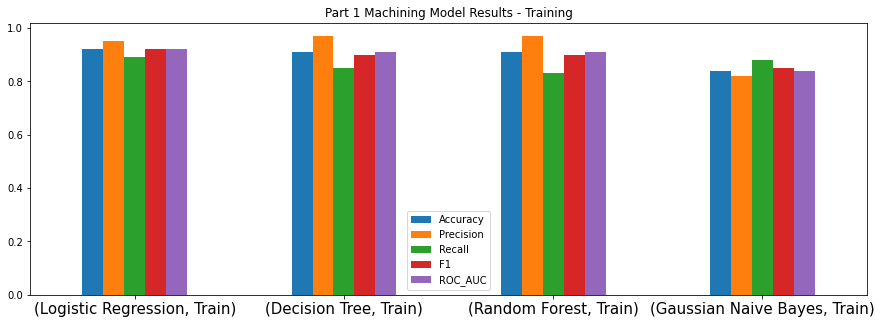

In [ ]:
Part_1_results.T.iloc[[0,2,4,6],:].plot.bar(figsize=(15, 5))
plt.xticks(rotation = 0, fontsize=15)
plt.title('Part 1 Machining Model Results - Training')
plt.show()

In [ ]:
# The test results
Part_1_results.T.iloc[[1,3,5,7],:]

Accuracy  Precision  Recall    F1  ROC_AUC
Logistic Regression  Test      0.92       0.95    0.89  0.92     0.92
Decision Tree        Test      0.90       0.96    0.84  0.90     0.90
Random Forest        Test      0.90       0.96    0.83  0.89     0.90
Gaussian Naive Bayes Test      0.84       0.81    0.88  0.85     0.84

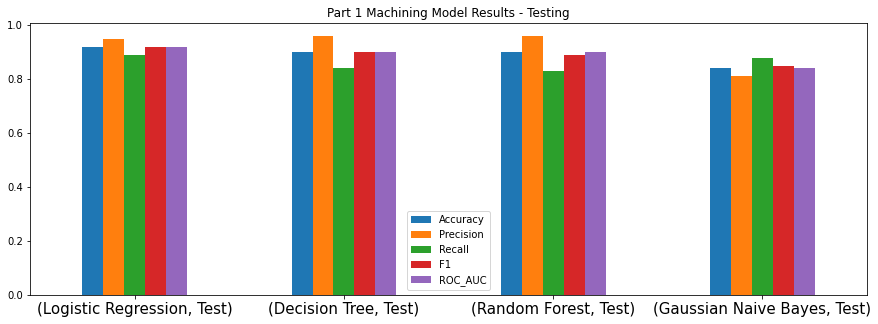

In [ ]:
Part_1_results.T.iloc[[1,3,5,7],:].plot.bar(figsize=(15, 5))
plt.xticks(rotation = 0, fontsize=15)
plt.title('Part 1 Machining Model Results - Testing')
plt.show()

#### Verdict

By comparing the metrics across the four machine learning models, we can see that all models performed well on the training and test datasets. No overfitting or underfitting was observed. Logistic Regression performed relatively better than the other three models, plus Logistic Regression took the least computational cost (fastest in terms of CV and fitting) among the four algorithms. **Therefore, the Logistic Regression model is selected to be the best model for sentiment analysis and will be used in Part 2 of this project.**

# 2.0 Sentiment Classification

## 2.1 Russia Ukraine War - Tweets Sentiment Analysis

### 2.1.0 Text Cleaning

In [ ]:
def remove_stopword_multilingual(text):
    stop_words = set(stopwords.words(['english', 'french', 'german']))
    stop_words.add('rt')
    stop_words.add('im')
    stop_words.add('iam')
    stop_words.add('int')
    
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
# read tweets data ('english', 'french', 'german' tweets)
p2_data_tweet = pd.read_csv('UkraineCombinedTweetsDeduped.csv')
p2_data_tweet = p2_data_tweet[['language', 'text']]
p2_data_tweet = p2_data_tweet[p2_data_tweet['language'].isin(['en','de','fr'])].reset_index()

In [ ]:
## The text cleaning process is commented out
# p2_data_tweet['cleaned_text'] = p2_data_tweet['text'].apply(remove_urls).apply(strip_all_tags).apply(lambda x: x.lower()).apply(remove_stopword_multilingual).apply(clean_text).apply(lemmatize_text).apply(remove_stopword_multilingual)

In [ ]:
## Save the cleaned tweets as csv
# p2_data_tweet['cleaned_text'].to_csv('p2_data_tweet_text_cleaned.csv', index = None, header=True)

In [ ]:
p2_tweet = pd.read_csv('p2_data_tweet_text_cleaned.csv')

# Drop rows that contain NaN
p2_tweet.dropna(inplace=True)
p2_tweet

cleaned_text
0      dear vaccine advocate take covid mrna shoot bo...
1      animal shelter dog cat need help raise fund fo...
2      welcome shelter locate ukraine kyiv shelter ne...
3      good news may miss first shipment wheat operat...
4                     opinion ukraine fight language cnn
...                                                  ...
29610       russian tank hit ukrainian mine date unknown
29611  turks putin hand pick mediator continue thumb ...
29612  everything usual another russian government pe...
29613                                twisted firestarter
29614  people say us well shape trump office remind u...

[29562 rows x 1 columns]

### 2.1.1 Apply Pre-trained sentiment classification model

In [ ]:
def VADER(df_cleaned_text):
    sid=SentimentIntensityAnalyzer()
    def vader_func(text):
        return(sid.polarity_scores(text)['compound'])
    
    # Compound score thresholds 
    # positive sentiment : (compound score >= 0.05) 
    # neutral sentiment : (-0.05 <compound score < 0.05) 
    # negative sentiment : (compound score <= -0.05)
    
    df_cleaned_text['Compound_Sentiment_score'] = df_cleaned_text['cleaned_text'].apply(vader_func)
    df_cleaned_text['Sentiment_type_bool'] = df_cleaned_text['Compound_Sentiment_score'].apply(lambda x : 1 if(x>=0.05) else 0 if(x<=-0.05) else 'Neutral')
    df_cleaned_text['Sentiment_type_str'] = df_cleaned_text['Compound_Sentiment_score'].apply(lambda x : 'Positive' if(x>=0.05) else 'Negative' if(x<=-0.05) else 'Neutral')

In [ ]:
VADER(p2_tweet)

In [ ]:
# Remove the Neutral Tweets
p2_tweet_bool = p2_tweet[p2_tweet['Sentiment_type_bool'].isin(['Neutral'])==False]

In [ ]:
p2_tweet_bool

cleaned_text  \
0      dear vaccine advocate take covid mrna shoot bo...   
1      animal shelter dog cat need help raise fund fo...   
2      welcome shelter locate ukraine kyiv shelter ne...   
3      good news may miss first shipment wheat operat...   
4                     opinion ukraine fight language cnn   
...                                                  ...   
29608  ever wonder brian bolland sov judge dredd eagl...   
29609  missile launch belgorod tonight fall belgorod ...   
29611  turks putin hand pick mediator continue thumb ...   
29612  everything usual another russian government pe...   
29614  people say us well shape trump office remind u...   

       Compound_Sentiment_score Sentiment_type_bool Sentiment_type_str  
0                       -0.5719                   0           Negative  
1                        0.6249                   1           Positive  
2                        0.7964                   1           Positive  
3                       -0.6705                   0           Negative  
4                       -0.3818                   0           Negative  
...                         ...                 ...                ...  
29608                    0.2732                   1           Positive  
29609                   -0.3182                   0           Negative  
29611                    0.4939                   1           Positive  
29612                    0.4215                   1           Positive  
29614                    0.2732                   1           Positive  

[18521 rows x 4 columns]

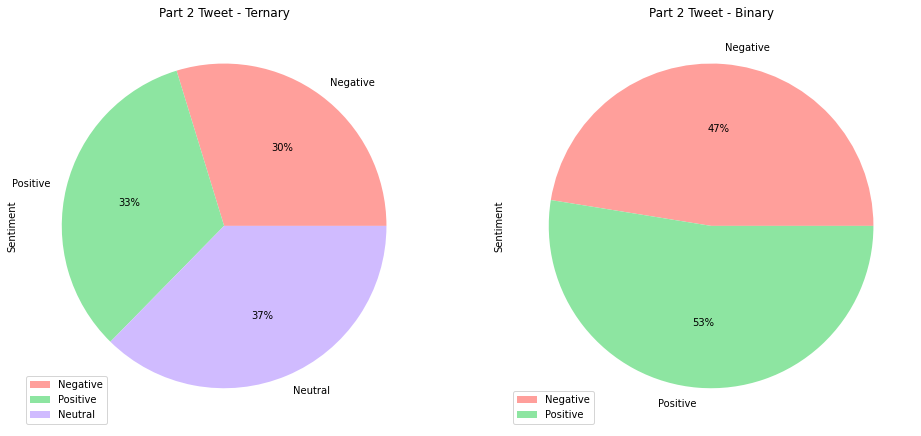

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

colors = sns.color_palette('pastel')[2:5]
temp = colors[0]
colors[0] = colors[1]
colors[1] = temp

p2_tweet['Sentiment_type_str'].value_counts(ascending=True).to_frame().plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[0])
axes[0].set_title('Part 2 Tweet - Ternary')
axes[0].set_ylabel('Sentiment')

p2_tweet_bool['Sentiment_type_str'].value_counts(ascending=True).to_frame().plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[1])
axes[1].set_title('Part 2 Tweet - Binary')
axes[1].set_ylabel('Sentiment')

plt.show()

### 2.1.2 Apply the Trained Sentiment Classification Model from Part 1

In [ ]:
p2_tweet_bool = pd.DataFrame(p2_tweet_bool.values, columns = p2_tweet_bool.columns)

In [ ]:
X_p2_tweet = p2_tweet_bool['cleaned_text'].to_list()
X_p2_tweet_idf = tfidf.transform(X_p2_tweet)
X_p2_tweet_idf = pd.DataFrame(X_p2_tweet_idf.todense(), columns = tfidf.get_feature_names_out())

In [ ]:
# predict for part 2 cleaned data
y_p2_tweet_pred_logit = tuned_model_logit.predict(X_p2_tweet_idf)
p2_tweet_bool['P1_pred'] = y_p2_tweet_pred_logit
y_p2_tweet_pred_logit = pd.DataFrame(y_p2_tweet_pred_logit, columns = ['label'])

In [ ]:
p2_tweet_bool

cleaned_text  \
0      dear vaccine advocate take covid mrna shoot bo...   
1      animal shelter dog cat need help raise fund fo...   
2      welcome shelter locate ukraine kyiv shelter ne...   
3      good news may miss first shipment wheat operat...   
4                     opinion ukraine fight language cnn   
...                                                  ...   
18516  ever wonder brian bolland sov judge dredd eagl...   
18517  missile launch belgorod tonight fall belgorod ...   
18518  turks putin hand pick mediator continue thumb ...   
18519  everything usual another russian government pe...   
18520  people say us well shape trump office remind u...   

      Compound_Sentiment_score Sentiment_type_bool Sentiment_type_str  P1_pred  
0                      -0.5719                   0           Negative        0  
1                       0.6249                   1           Positive        0  
2                       0.7964                   1           Positive        1  
3                      -0.6705                   0           Negative        1  
4                      -0.3818                   0           Negative        0  
...                        ...                 ...                ...      ...  
18516                   0.2732                   1           Positive        1  
18517                  -0.3182                   0           Negative        0  
18518                   0.4939                   1           Positive        0  
18519                   0.4215                   1           Positive        0  
18520                   0.2732                   1           Positive        0  

[18521 rows x 5 columns]

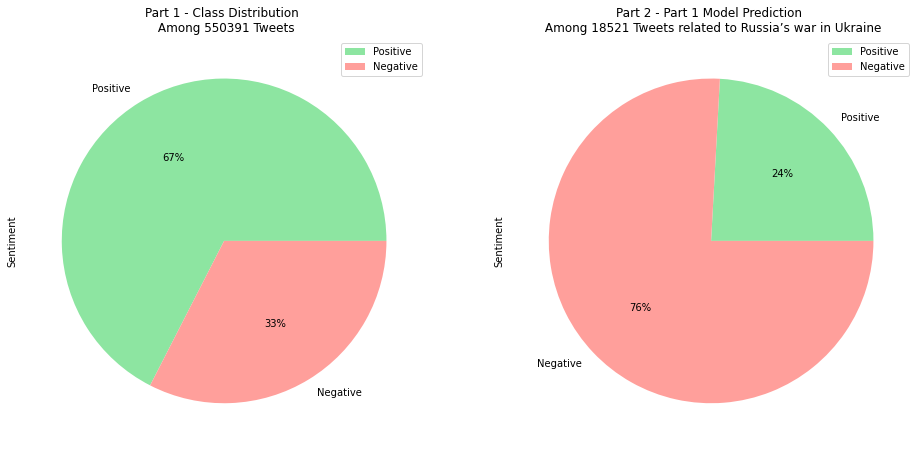

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
colors = sns.color_palette('pastel')[2:5]

p1_data['label'].value_counts().to_frame().rename(index ={0: 'Negative', 1: 'Positive'}).plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[0])
axes[0].set_title('Part 1 - Class Distribution \n Among %s Tweets'%len(p1_data['label']))
axes[0].set_ylabel('Sentiment')

y_p2_tweet_pred_logit['label'].value_counts(ascending=True).to_frame().rename(index ={0: 'Negative', 1: 'Positive'}).plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[1])
axes[1].set_title('Part 2 - Part 1 Model Prediction \n Among %s Tweets related to Russia’s war in Ukraine'%len(y_p2_tweet_pred_logit['label']))
axes[1].set_ylabel('Sentiment')

plt.show()

## 2.2 Russia Ukraine War - Reddit Sentiment Analysis

### 2.2.0 Reddit Comments Scraping

In [ ]:
# # Web scraping the Reddit comments about Russia Ukraine War
# reddit = praw.Reddit(user_agent='ConclusionWooden',
#                 client_id='FlmNnwdW6YVim2ZoghLlwg',
#                 client_secret='K3WagsQjw0ZC_mz9NDjjWej6OiTB0w',
#                 check_for_async=False)

# submission = reddit.submission("t003vl")

# comments = []
# submission.comments.replace_more(limit=30)
# for top_level_comment in submission.comments:
#     comments.append(top_level_comment.body)
#     for second_level_comment in top_level_comment.replies:
#         comments.append(second_level_comment.body)
# news= pd.DataFrame({"comment" : comments})
# news.to_csv('reddit_comments.csv', index = None, header=True)

### 2.2.1 Text Cleaning

In [ ]:
# Remove non-English words
def english_only(text):
    words = set(nltk.corpus.words.words())

    return ' '.join(w for w in nltk.wordpunct_tokenize(text) \
                    if w.lower() in words or not w.isalpha())

In [ ]:
# read Reddit data
p2_data_reddit = pd.read_csv('reddit_comments.csv')
p2_data_reddit = p2_data_reddit['comment'].to_frame()

In [ ]:
p2_data_reddit

comment
0     The comments in this thread are sorted by new ...
1     Sad day for humanity, there are no good outcom...
2                                            Fuck putin
3                                             [removed]
4     [Holy shit, a child was just struck by an expl...
...                                                 ...
3255  Deploying nuclear weapons would probably guara...
3256  I doubt it, since they want the territories, w...
3257  Possible, yes, probable, no.\n\n&#x200B;\n\n&#...
3258  Unlikely. For now it seems to just invade Ukra...
3259  It’s possible Russia will deploy nukes if they...

[3260 rows x 1 columns]

In [ ]:
# # The text cleaning process is commented out
# p2_data_reddit['cleaned_text'] = p2_data_reddit['comment'].apply(remove_urls).apply(strip_all_tags).apply(lambda x: x.lower()).apply(remove_stopword).apply(clean_text).apply(lemmatize_text).apply(remove_stopword).apply(english_only)

In [ ]:
# # Save the cleaned tweets as csv
# p2_data_reddit['cleaned_text'].to_csv('p2_data_reddit_text_cleaned.csv', index = None, header=True)

In [ ]:
p2_reddit = pd.read_csv('p2_data_reddit_text_cleaned.csv')

# Drop rows that contain NaN
p2_reddit.dropna(inplace=True)
p2_reddit

cleaned_text
0     comment thread sort new due rapid development ...
1     sad day humanity good waste distraction destru...
3                                                remove
4     holy child strike explosion ride bike street s...
5     click stream weird see large street completely...
...                                                 ...
3255  deploy nuclear weapon would probably guarantee...
3256        doubt since want territory would nuke place
3257                    possible yes probable hope pray
3258  unlikely seem invade deploy another puppet inc...
3259  possible russia deploy nuke consider sanction ...

[3231 rows x 1 columns]

### 2.2.2 Apply Pre-trained sentiment classification model

In [ ]:
VADER(p2_reddit)

In [ ]:
# Remove the Neutral Tweets
p2_reddit_bool = p2_reddit[p2_reddit['Sentiment_type_bool'].isin(['Neutral'])==False]

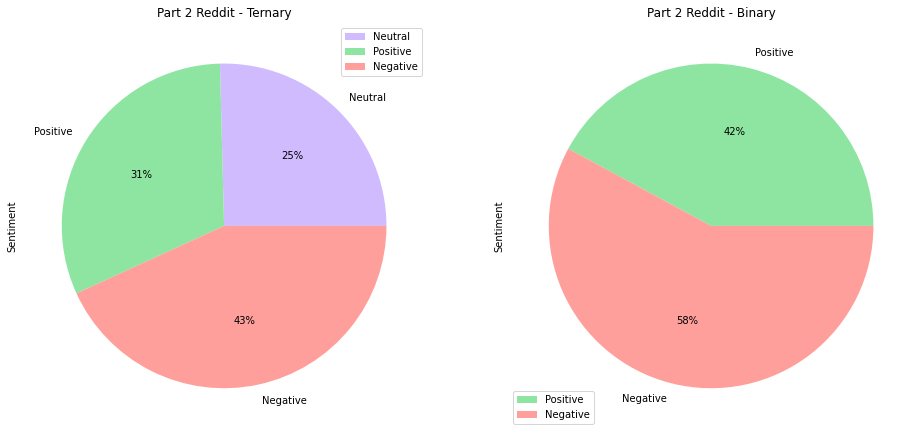

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
colors = sns.color_palette('pastel')[2:5]
colors = [colors[2],colors[0],colors[1]]

p2_reddit['Sentiment_type_str'].value_counts(ascending=True).to_frame().plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[0])
axes[0].set_title('Part 2 Reddit - Ternary')
axes[0].set_ylabel('Sentiment')

colors = [colors[1],colors[2]]
p2_reddit_bool['Sentiment_type_str'].value_counts(ascending=True).to_frame().plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[1])
axes[1].set_title('Part 2 Reddit - Binary')
axes[1].set_ylabel('Sentiment')

plt.show()

### 2.2.3 Apply the Trained Sentiment Classification Model from Part 1

In [ ]:
p2_reddit_bool = pd.DataFrame(p2_reddit_bool.values, columns = p2_reddit_bool.columns)

In [ ]:
X_p2_reddit = p2_reddit_bool['cleaned_text'].to_list()
X_p2_reddit_idf = tfidf.transform(X_p2_reddit)
X_p2_reddit_idf = pd.DataFrame(X_p2_reddit_idf.todense(), columns = tfidf.get_feature_names_out())

In [ ]:
# predict for part 2 cleaned data
y_p2_reddit_pred_logit = tuned_model_logit.predict(X_p2_reddit_idf)
p2_reddit_bool['P1_pred'] = y_p2_reddit_pred_logit
y_p2_reddit_pred_logit = pd.DataFrame(y_p2_reddit_pred_logit, columns = ['label'])

In [ ]:
p2_reddit_bool

cleaned_text  \
0     comment thread sort new due rapid development ...   
1     sad day humanity good waste distraction destru...   
2     holy child strike explosion ride bike street s...   
3     click stream weird see large street completely...   
4     many idiot comment expect see call duty style ...   
...                                                 ...   
2405  deploy nuclear weapon would probably guarantee...   
2406        doubt since want territory would nuke place   
2407                    possible yes probable hope pray   
2408  unlikely seem invade deploy another puppet inc...   
2409  possible russia deploy nuke consider sanction ...   

     Compound_Sentiment_score Sentiment_type_bool Sentiment_type_str  P1_pred  
0                      0.2732                   1           Positive        1  
1                     -0.9217                   0           Negative        0  
2                     -0.6705                   0           Negative        0  
3                     -0.4201                   0           Negative        0  
4                     -0.5478                   0           Negative        0  
...                       ...                 ...                ...      ...  
2405                  -0.4939                   0           Negative        0  
2406                   -0.296                   0           Negative        0  
2407                   0.7845                   1           Positive        1  
2408                   0.6369                   1           Positive        1  
2409                  -0.1531                   0           Negative        0  

[2410 rows x 5 columns]

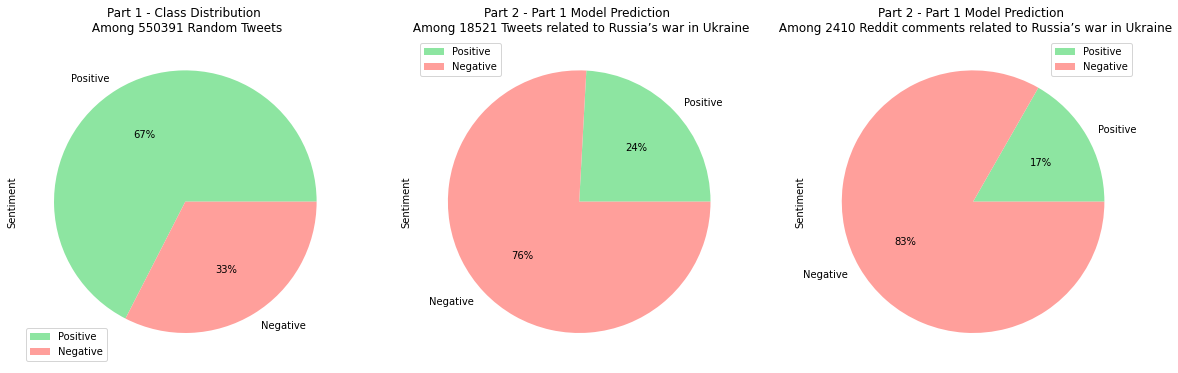

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
colors = sns.color_palette('pastel')[2:4]

p1_data['label'].value_counts().to_frame().rename(index ={0: 'Negative', 1: 'Positive'}).plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[0])
axes[0].set_title('Part 1 - Class Distribution \n Among %s Random Tweets'%len(p1_data['label']))
axes[0].set_ylabel('Sentiment')

y_p2_tweet_pred_logit['label'].value_counts(ascending=True).to_frame().rename(index ={0: 'Negative', 1: 'Positive'}).plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[1])
axes[1].set_title('Part 2 - Part 1 Model Prediction \n Among %s Tweets related to Russia’s war in Ukraine'%len(y_p2_tweet_pred_logit['label']))
axes[1].set_ylabel('Sentiment')

y_p2_reddit_pred_logit['label'].value_counts(ascending=True).to_frame().rename(index ={0: 'Negative', 1: 'Positive'}).plot(kind='pie', subplots=True, autopct='%.0f%%', colors = colors, ax=axes[2])
axes[2].set_title('Part 2 - Part 1 Model Prediction \n Among %s Reddit comments related to Russia’s war in Ukraine'%len(y_p2_reddit_pred_logit['label']))
axes[2].set_ylabel('Sentiment')

plt.show()

Upon classifying the sentiments of the war-related social media datasets, we can conclude that most people on social media are showing negative emotions against Russia’s war in Ukraine, and Reddit users are showing more negative emotions than Twitter users. 

Note that more detailed results comparisons and discussions are included in the report.

# 3.0 Factor and Topics Identification via Machine Learning

## 3.1 LDA and Word Cloud Implementations

In [ ]:
def TFIDF(text):
    tfidf = TfidfVectorizer(lowercase=True, max_features = 500)

    temp = text.to_list()
    text_idf = tfidf.fit_transform(temp)

    text_idf_df = pd.DataFrame(text_idf.todense(), columns = tfidf.get_feature_names_out())
    return [text_idf_df, text_idf, tfidf]

In [ ]:
# LDA - 30 Topics per Sentiment and 20 Words per Topic
def LDA(text_tfidf):
    text_tfidf_names = text_tfidf.columns.tolist()
    
    lda_model = LatentDirichletAllocation(n_components = 30, max_iter = 20, random_state = 20)

    x_topics = lda_model.fit_transform(text_tfidf)

    topic_words = lda_model.components_

    n_top_words = 21

    topic_text = []

    for i, topic_dist in enumerate(topic_words):

        sorted_topic_dist = np.argsort(topic_dist)

        topicwords = np.array(text_tfidf_names)[sorted_topic_dist]

        topicwords = topicwords[:-n_top_words:-1]

        topic_text.append(topicwords)
        
    return [topic_text, lda_model]

In [ ]:
def topic_cloud(topic_text, mask, title):
    for i in topic_text:
        i = ' '.join(i)

    flat_text = [item for sublist in topic_text for item in sublist]
    text = ' '.join(flat_text)

    stopwords = set(STOPWORDS)
    stopwords = STOPWORDS.update({'china','say','go','see','amp','day','look', 'august','russian','ukraine','ukrainian','russia',
                     'make', 'world', 'country', 'one', 'take', 'need','new','good','well','great','friday'})

    wordcloud = WordCloud(stopwords=stopwords, max_words=200, mask = mask, background_color="white").generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    
    fig=plt.figure(figsize=(15, 8))
    plt.title(title)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
# Load image from GitHub repository
flag_url = 'https://raw.githubusercontent.com/HaowenPeterLi/MIE1624_Project/main/Flag_of_Ukraine.png'
map_url = 'https://raw.githubusercontent.com/HaowenPeterLi/MIE1624_Project/main/UK_map.png'

image_flag = Image.open(requests.get(flag_url, stream = True).raw).convert('RGB')
image_map = Image.open(requests.get(map_url, stream = True).raw).convert('RGB')

In [ ]:
# Change background to [255, 255, 255] for masking
def white_background(mask):
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j].sum() == 0:
                mask[i][j] = [255, 255, 255]
    return mask

In [ ]:
map_mask = white_background(np.array(image_map))
flag_mask = np.array(image_flag)

## 3.2 Twitter Topics

In [ ]:
p2_tweet_bool_neg = p2_tweet_bool[p2_tweet_bool['P1_pred'] == 0]
p2_tweet_bool_pos = p2_tweet_bool[p2_tweet_bool['P1_pred'] == 1]

In [ ]:
# The commented out code was used to apply LDA on VADER results
# p2_tweet_bool_neg = p2_tweet_bool[p2_tweet_bool['Sentiment_type_bool'] == 0]
# p2_tweet_bool_pos = p2_tweet_bool[p2_tweet_bool['Sentiment_type_bool'] == 1]

In [ ]:
pos_twitter_tfidf = TFIDF(p2_tweet_bool_pos['cleaned_text'])
neg_twitter_tfidf = TFIDF(p2_tweet_bool_neg['cleaned_text'])

In [ ]:
pos_twitter_LDA = LDA(pos_twitter_tfidf[0])
pos_twitter_topic_text = pos_twitter_LDA[0]
neg_twitter_LDA = LDA(neg_twitter_tfidf[0])
neg_twitter_topic_text = neg_twitter_LDA[0]

### 3.2.0 Positive Twitter Topics

In [ ]:
pd.set_option('display.max_rows', 10)
pd.concat({'Topics': pd.DataFrame(pos_twitter_topic_text)})

0         1           2        3          4          5   \
Topics 0         wow  invasion  commission     glad      leave      right   
       1      please      look      follow  support        fed    america   
       2        good   morning         air     team       work     friday   
       3    everyone     think       super    every       nato  something   
       4        join      free         amp       pm       live       easy   
...              ...       ...         ...      ...        ...        ...   
       25        day       god       bless   always  celebrate       life   
       26    special    chance   operation    story       tell     lovely   
       27  beautiful      cool        land  perfect        big      biden   
       28    welcome     great     nuclear  discuss   security      plant   
       29       ever       see       would   winner        end       good   

                     6         7           8         9       10  \
Topics 0        country     house         get       amp  reason   
       1            tax     front      member    manage     pre   
       2        defense      real       price      test   great   
       3          today  american    possible       pay     ask   
       4            ban      food         aug       try    feel   
...                 ...       ...         ...       ...     ...   
       25  independence       set        good    update  family   
       26          unit     maybe       issue  ministry  wonder   
       27           two    become  appreciate      area    time   
       28         power   erdogan        join    region   build   
       29          rest    europe       could      idea  invade   

                       11          12       13         14             15  \
Topics 0          support        make     hard     report            say   
       1            level         oil   highly      depot           home   
       2               ua  incredible   effort  excellent          thank   
       3          deserve         day     good    evening      ukrainian   
       4             visa       agree  citizen       save  international   
...                   ...         ...      ...        ...            ...   
       25            love     ukraine      one       year            new   
       26        military       scale      amp    ukraine           work   
       27            good         one     read     family           look   
       28  administration      source    ready        amp       zelensky   
       29            mean        burn     tank         us          world   

                16         17          18       19  
Topics 0   western  volunteer        help     mine  
       1      port       city  everything      amp  
       2       etc    ukraine         amp     take  
       3   service    russian        need   august  
       4       let       time       putin    right  
...            ...        ...         ...      ...  
       25   august        way        take     well  
       26  russian       home     defense      see  
       27     back       need        feel    power  
       28  ukraine     russia   situation  economy  
       29   attack    twitter        well   russia  

[30 rows x 20 columns]

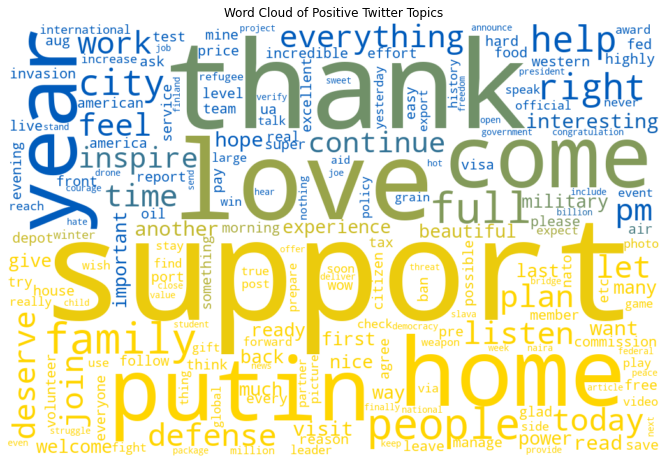

In [ ]:
topic_cloud(pos_twitter_topic_text, flag_mask, 'Word Cloud of Positive Twitter Topics')

In [ ]:
pos_twitter_vis = pyLDAvis.sklearn.prepare(pos_twitter_LDA[1], pos_twitter_tfidf[1], pos_twitter_tfidf[2])
pos_twitter_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22     0.467359 -0.038001       1        1  13.849331
11    -0.099865 -0.048378       2        1   4.327067
14    -0.063527 -0.077109       3        1   4.008875
24    -0.064115  0.049694       4        1   4.007890
28    -0.077555  0.066644       5        1   3.824700
9      0.076446 -0.039744       6        1   3.660532
16    -0.100618  0.055458       7        1   3.538038
23    -0.080806  0.057877       8        1   3.425914
8     -0.074416 -0.043096       9        1   3.405544
20    -0.066987 -0.113333      10        1   3.342255
5     -0.049689 -0.105036      11        1   3.255416
15    -0.053024 -0.049806      12        1   3.136416
2     -0.058095 -0.092988      13        1   3.079133
18    -0.084380  0.018907      14        1   3.056480
29    -0.068680 -0.102380      15        1   2.938318
10    -0.029748 -0.007899      16        1   2.818141
12     0.019808  0.014611      17        1   2.763897
3     -0.045223 -0.015013      18        1   2.741356
0     -0.065160  0.151748      19        1   2.702815
19     0.015757  0.019728      20        1   2.671504
1      0.121713  0.141771      21        1   2.667052
17    -0.032099  0.123035      22        1   2.518802
26     0.060621 -0.024085      23        1   2.503187
4      0.035562  0.091011      24        1   2.497929
21     0.010707  0.235102      25        1   2.452840
7      0.034854  0.052716      26        1   2.449160
25     0.041403 -0.202184      27        1   2.248372
27     0.032393  0.007793      28        1   2.177465
6      0.044817 -0.154254      29        1   2.042905
13     0.152546  0.027212      30        1   1.888667, topic_info=        Term        Freq       Total Category  logprob  loglift
430    thank  132.000000  132.000000  Default  30.0000  30.0000
35   awesome  145.000000  145.000000  Default  29.0000  29.0000
483      win   68.000000   68.000000  Default  28.0000  28.0000
195     hire  135.000000  135.000000  Default  27.0000  27.0000
208   income  134.000000  134.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
229    large    0.041778   13.711370  Topic30  -8.4962  -1.8243
180    great    0.041778   96.037527  Topic30  -8.4962  -3.7708
368  russian    0.041778   69.470491  Topic30  -8.4962  -3.4470
245     long    0.041778  140.514727  Topic30  -8.4962  -4.1514
393     song    0.041778    8.357849  Topic30  -8.4962  -1.3293

[1175 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         2  0.091200          able
0         7  0.547200          able
0         9  0.182400          able
0        12  0.091200          able
1         6  0.221372        accord
...     ...       ...           ...
498      30  0.500676  zaporizhzhia
499       2  0.084035      zelensky
499       5  0.588246      zelensky
499       6  0.168070      zelensky
499      14  0.084035      zelensky

[1911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 12, 15, 25, 29, 10, 17, 24, 9, 21, 6, 16, 3, 19, 30, 11, 13, 4, 1, 20, 2, 18, 27, 5, 22, 8, 26, 28, 7, 14])

### 3.2.1 Negative Twitter Topics

In [ ]:
pd.concat({'Topics': pd.DataFrame(neg_twitter_topic_text)})

0        1       2         3         4           5   \
Topics 0       attack     come    hold      plan     front    defender   
       1        start     free   gross     truth    forget  understand   
       2         lose  germany     buy       oil       act    minister   
       3        think    thing    sell        th       top     soldier   
       4    president     talk  united       try      hero      states   
...               ...      ...     ...       ...       ...         ...   
       25      defeat  western   black      land       sea       bring   
       26  propaganda   crisis   death   control  sanction    official   
       27         amp      way   party  criminal      care         run   
       28        kill     save   child   kharkiv  civilian     missile   
       29     million    armed     aid      anti     force     protect   

                 6         7            8         9        10        11  \
Topics 0      write     allow           ua      line     safe  occupier   
       1       word    danger         back     share     full    update   
       2      india      fall      economy  position     ally       amp   
       3   language      keep         open     photo     life  invasion   
       4       meet   illegal         hide     grain   dollar       say   
...             ...       ...          ...       ...      ...       ...   
       25  conflict       win         half      true     feel    soviet   
       26       arm      rise       family       see    story      week   
       27    invade  business         seem   believe     away      take   
       28    system      live     thousand     large   modern  russians   
       29  announce   provide  destruction    result  ukraine     worth   

                     12        13        14         15       16        17  \
Topics 0        capture    behind   russian  ukrainian  ukraine     still   
       1   intelligence     scale    source     bridge     stop  invasion   
       2          price       gas       say        far  russian     china   
       3        general  remember     visit      wound  russian        go   
       4          order     steal  everyone      trade     part   ukraine   
...                 ...       ...       ...        ...      ...       ...   
       25         drive  collapse     union    crimean  ukraine    remain   
       26       include       put       amp       work  russian       say   
       27        people      like    russia        get       go   ukraine   
       28       russian  transfer    people    hundred      two   morning   
       29      military   billion    suffer      enemy  missile     total   

                18           19  
Topics 0       day        claim  
       1      help        never  
       2   country       russia  
       3    policy         know  
       4     china      another  
...            ...          ...  
       25      end  afghanistan  
       26    price           us  
       27     time          one  
       28   attack        least  
       29  package        himar  

[30 rows x 20 columns]

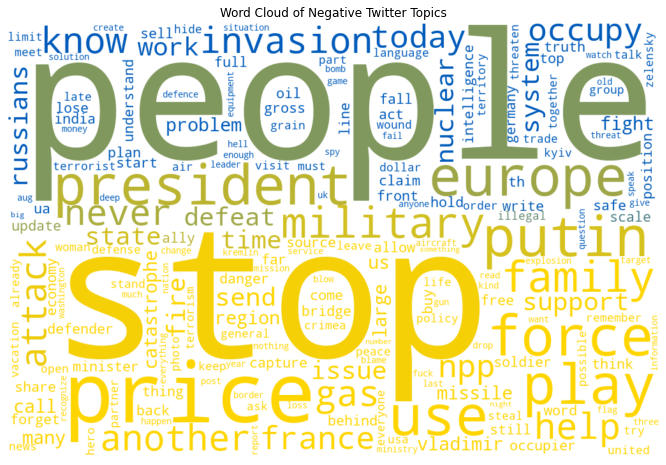

In [ ]:
topic_cloud(neg_twitter_topic_text, flag_mask, 'Word Cloud of Negative Twitter Topics')

In [ ]:
neg_twitter_vis = pyLDAvis.sklearn.prepare(neg_twitter_LDA[1], neg_twitter_tfidf[1], neg_twitter_tfidf[2])
neg_twitter_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12    -0.102442  0.016658       1        1  6.115102
28    -0.218945 -0.139188       2        1  5.219006
20    -0.224957 -0.134150       3        1  4.338805
7     -0.160475 -0.075984       4        1  3.799208
23     0.149579 -0.051478       5        1  3.761330
29    -0.173727 -0.120928       6        1  3.728994
27     0.159154 -0.042869       7        1  3.710139
19     0.059904 -0.079026       8        1  3.476570
9      0.010038 -0.070935       9        1  3.451060
11     0.155164 -0.079498      10        1  3.435971
13    -0.005711 -0.073989      11        1  3.356014
21     0.122823 -0.027826      12        1  3.278357
4      0.078839 -0.007058      13        1  3.269846
18     0.150240 -0.048166      14        1  3.261969
2      0.097518 -0.001632      15        1  3.166592
17     0.072591 -0.100316      16        1  3.156862
22    -0.045287 -0.001846      17        1  3.129825
0     -0.019632 -0.037146      18        1  3.117853
6     -0.075130  0.098059      19        1  3.089227
5     -0.127613 -0.005702      20        1  3.075742
26     0.089354 -0.057173      21        1  3.063599
10    -0.042573  0.302586      22        1  2.980797
3      0.083614  0.021265      23        1  2.971589
25     0.004719  0.023156      24        1  2.888140
24     0.033076  0.088301      25        1  2.703643
15    -0.089706  0.249579      26        1  2.644300
1      0.029558  0.146311      27        1  2.601360
16    -0.013308  0.092042      28        1  2.511731
14    -0.149641  0.070082      29        1  2.411119
8      0.152975  0.046870      30        1  2.285248, topic_info=         Term        Freq       Total Category  logprob  loglift
468       via  205.000000  205.000000  Default  30.0000  30.0000
469     video  171.000000  171.000000  Default  29.0000  29.0000
327      play  182.000000  182.000000  Default  28.0000  28.0000
326     plant  168.000000  168.000000  Default  27.0000  27.0000
302   nuclear  195.000000  195.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
19        amp    8.717857  305.785100  Topic30  -4.4164   0.2212
468       via    6.202683  205.570794  Topic30  -4.7568   0.2779
292      need    5.443303  149.398519  Topic30  -4.8873   0.4665
179      give    4.998219   98.059317  Topic30  -4.9727   0.8022
270  military    5.182174  176.267543  Topic30  -4.9365   0.2519

[1203 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.941290    access
0        23  0.037652    access
1         1  0.035883    accord
1         4  0.233236    accord
1         6  0.125589    accord
...     ...       ...       ...
499      14  0.159074  zelensky
499      15  0.017675  zelensky
499      20  0.388848  zelensky
499      23  0.017675  zelensky
499      26  0.070700  zelensky

[3045 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 29, 21, 8, 24, 30, 28, 20, 10, 12, 14, 22, 5, 19, 3, 18, 23, 1, 7, 6, 27, 11, 4, 26, 25, 16, 2, 17, 15, 9])

## 3.3 Reddit Topics

In [ ]:
p2_reddit_bool

cleaned_text  \
0     comment thread sort new due rapid development ...   
1     sad day humanity good waste distraction destru...   
2     holy child strike explosion ride bike street s...   
3     click stream weird see large street completely...   
4     many idiot comment expect see call duty style ...   
...                                                 ...   
2405  deploy nuclear weapon would probably guarantee...   
2406        doubt since want territory would nuke place   
2407                    possible yes probable hope pray   
2408  unlikely seem invade deploy another puppet inc...   
2409  possible russia deploy nuke consider sanction ...   

     Compound_Sentiment_score Sentiment_type_bool Sentiment_type_str  P1_pred  
0                      0.2732                   1           Positive        1  
1                     -0.9217                   0           Negative        0  
2                     -0.6705                   0           Negative        0  
3                     -0.4201                   0           Negative        0  
4                     -0.5478                   0           Negative        0  
...                       ...                 ...                ...      ...  
2405                  -0.4939                   0           Negative        0  
2406                   -0.296                   0           Negative        0  
2407                   0.7845                   1           Positive        1  
2408                   0.6369                   1           Positive        1  
2409                  -0.1531                   0           Negative        0  

[2410 rows x 5 columns]

In [ ]:
p2_reddit_bool_neg = p2_reddit_bool[p2_reddit_bool['P1_pred'] == 0]
p2_reddit_bool_pos = p2_reddit_bool[p2_reddit_bool['P1_pred'] == 1]

In [ ]:
# The commented out code was used to apply LDA on VADER results
# p2_reddit_bool_neg = p2_reddit_bool[p2_reddit_bool['Sentiment_type_bool'] == 0]
# p2_reddit_bool_pos = p2_reddit_bool[p2_reddit_bool['Sentiment_type_bool'] == 1]

In [ ]:
pos_reddit_tfidf = TFIDF(p2_reddit_bool_pos['cleaned_text'])
neg_reddit_tfidf = TFIDF(p2_reddit_bool_neg['cleaned_text'])

In [ ]:
pos_reddit_LDA = LDA(pos_reddit_tfidf[0])
pos_reddit_topic_text = pos_reddit_LDA[0]
neg_reddit_LDA = LDA(neg_reddit_tfidf[0])
neg_reddit_topic_text = neg_reddit_LDA[0]

### 3.3.0 Positive Reddit Topics

In [ ]:
pd.concat({'Topics': pd.DataFrame(pos_reddit_topic_text)})

0        1        2       3            4           5   \
Topics 0    could     well     wish  people          wow     support   
       1     luck     good    might      go         need         say   
       2    award     free  amazing  likely         nice   wholesome   
       3      big     care     make   world       medium        good   
       4      yes   prayer     good    take         well  helicopter   
...           ...      ...      ...     ...          ...         ...   
       25    easy      day  soldier     ago         hour       bless   
       26  safety  country   happen  anyone  consequence       small   
       27   thank    award     give     get    wholesome      people   
       28      go     life     sure   world       pretty        well   
       29  please    ready   really  person        troop       peace   

                 6           7         8             9        10         11  \
Topics 0        say      russia      make        action      big   military   
       1   bankrupt         get      hope          move  support     family   
       2         go        army    almost          post    still     really   
       3       love      chance  straight           man     last       area   
       4       holy         god      folk           fun      see      place   
...             ...         ...       ...           ...      ...        ...   
       25       god       thank    future      birthday    stand  hopefully   
       26    common        part    planet    chancellor     like  wonderful   
       27      free       sadly      live   interesting      one    country   
       28      good  generation     crazy          food    water       feel   
       29       get        well  military  dictatorship     vote       help   

                 12          13        14        15       16      17  \
Topics 0    country        luck      line  actively   really   thank   
       1       help       world      else      well     show     let   
       2     invade       would      edit      case    sadly  around   
       3     russia          th  response     argue    point    sure   
       4        guy  government      hope     bless    video   leave   
...             ...         ...       ...       ...      ...     ...   
       25       cut        else    thread       man     rest   happy   
       26      well       heart      rest   nothing  declare    evil   
       27  together        well      come    fellow  missile    love   
       28      folk        back     scary      soon     know     get   
       29   welcome  appreciate  neighbor     point      far  safety   

                  18          19  
Topics 0      happen       allow  
       1    continue         bit  
       2    actually       world  
       3       alive     economy  
       4   situation  diplomatic  
...              ...         ...  
       25       nice       still  
       26        man    question  
       27        guy     twitter  
       28       like      thread  
       29     border         let  

[30 rows x 20 columns]

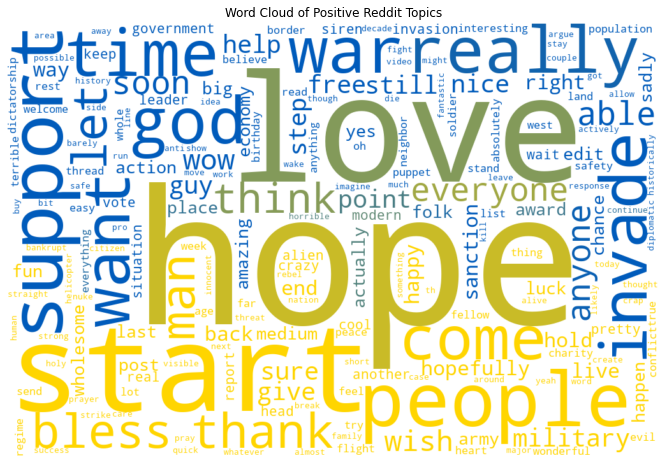

In [ ]:
topic_cloud(pos_reddit_topic_text, flag_mask, 'Word Cloud of Positive Reddit Topics')

In [ ]:
pos_reddit_vis = pyLDAvis.sklearn.prepare(pos_reddit_LDA[1], pos_reddit_tfidf[1], pos_reddit_tfidf[2])
pos_reddit_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.010924  0.266406       1        1  6.844414
6      0.277578 -0.001374       2        1  6.522354
19     0.017605 -0.018214       3        1  4.447367
5      0.005944 -0.027768       4        1  4.416579
27    -0.129161  0.007626       5        1  4.240435
14    -0.052767 -0.021237       6        1  4.003667
28    -0.062242 -0.098065       7        1  3.995094
13    -0.014235  0.007033       8        1  3.783410
1     -0.005777 -0.107525       9        1  3.565906
16    -0.044788 -0.026126      10        1  3.502343
24     0.040556 -0.020677      11        1  3.470931
23    -0.020888 -0.022379      12        1  3.337893
22     0.002069 -0.017752      13        1  3.333941
11     0.010037 -0.070412      14        1  3.234399
0      0.008368  0.033001      15        1  3.171003
3      0.010422  0.009066      16        1  3.169472
7     -0.004044  0.012876      17        1  3.149664
8      0.010924 -0.011444      18        1  3.127757
2     -0.107502  0.016423      19        1  3.017157
9      0.018119 -0.002078      20        1  2.989486
21    -0.025693 -0.012352      21        1  2.832790
4      0.034827 -0.042266      22        1  2.748674
18     0.071595  0.000716      23        1  2.641358
26     0.001584  0.007408      24        1  2.544585
12    -0.022464  0.034503      25        1  2.299447
20    -0.016186  0.014961      26        1  2.151812
29     0.002744  0.033015      27        1  1.947780
10    -0.007705 -0.018997      28        1  1.893605
15     0.007788  0.034695      29        1  1.839583
25     0.004217  0.040936      30        1  1.777097, topic_info=        Term      Freq     Total Category  logprob  loglift
408     stay  7.000000  7.000000  Default  30.0000  30.0000
42     award  6.000000  6.000000  Default  29.0000  29.0000
419  support  7.000000  7.000000  Default  28.0000  28.0000
497      yes  5.000000  5.000000  Default  27.0000  27.0000
255     luck  4.000000  4.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
431    thank  0.307001  6.155181  Topic30  -4.0865   1.0320
305      one  0.196432  4.723847  Topic30  -4.5330   0.8501
198     help  0.141042  3.703230  Topic30  -4.8643   0.7623
375      see  0.198130  5.286255  Topic30  -4.5244   0.7462
439     time  0.191667  6.040405  Topic30  -4.5576   0.5797

[1239 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1        14  0.599437  absolutely
4         3  0.381929      action
4        15  0.381929      action
11        1  0.485194         aid
16        1  0.488139        ally
...     ...       ...         ...
493      15  0.295919         wow
494       1  0.746283       write
496      21  0.246376        year
497      22  0.585409         yes
499       1  0.762546        zone

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 7, 20, 6, 28, 15, 29, 14, 2, 17, 25, 24, 23, 12, 1, 4, 8, 9, 3, 10, 22, 5, 19, 27, 13, 21, 30, 11, 16, 26])

### 3.3.1 Negative Reddit Topics

In [ ]:
pd.concat({'Topics': pd.DataFrame(neg_reddit_topic_text)})

0         1           2           3        4              5   \
Topics 0        sad      free      people         day   happen          heart   
       1       seem   nuclear     problem         non     ally            far   
       2    western     shoot  propaganda       plane    whole         either   
       3       wake  horrible   hopefully         let   people         medium   
       4     nobody     think        kind        holy    money           pray   
...             ...       ...         ...         ...      ...            ...   
       25  civilian      lose      defend  helicopter   change       response   
       26     still     thing        look        make    peace  unfortunately   
       27      want      land       allow      soviet     step          piece   
       28      hell  probably      stupid        must  citizen             go   
       29     guess     right       point         say     well          cause   

                    6         7        8         9       10         11  \
Topics 0        really        go     hear       see   world       word   
       1      collapse      sign      age     short    open     russia   
       2         force    pretty     sure      port   water       tank   
       3          hope  anything  support  terrible  social      doubt   
       4         agree      want      war    decide      go      start   
...                ...       ...      ...       ...     ...        ...   
       25        throw    person  prevent      past      eu  intervene   
       26          end       war     fall       see    like    imagine   
       27  destruction    former    power       big  expect        see   
       28       friend      face     much     today   world        bad   
       29          win   thought   regime   defense  russia      claim   

                  12        13       14          15         16        17  \
Topics 0        hope      come     know        head        put     would   
       1      united  economic     risk  militarily       away        go   
       2     economy   airport    exist        keep     market    russia   
       3       bunch      miss       go        soon     happen      deal   
       4    consider     would   russia   seriously  something   country   
...              ...       ...      ...         ...        ...       ...   
       25     attack      hell    point         man    imagine     exist   
       26       dead    happen      one        even       blow  powerful   
       27      close       end  instead         man       come    border   
       28        war    people     lose      russia       give    happen   
       29  literally   brother      air        fast        get     would   

                     18         19  
Topics 0            war       give  
       1         global        war  
       2          point       part  
       3          since   invasion  
       4         people     really  
...                 ...        ...  
       25  geopolitical    without  
       26          west      world  
       27          also       life  
       28         young    nothing  
       29          hope  president  

[30 rows x 20 columns]

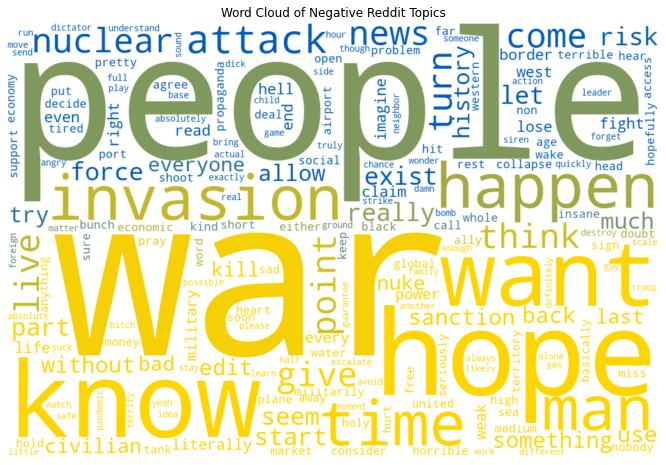

In [ ]:
topic_cloud(neg_reddit_topic_text, flag_mask, 'Word Cloud of Negative Reddit Topics')

In [ ]:
neg_reddit_vis = pyLDAvis.sklearn.prepare(neg_reddit_LDA[1], neg_reddit_tfidf[1], neg_reddit_tfidf[2])
neg_reddit_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24    -0.023369 -0.095066       1        1  5.156225
14    -0.123659 -0.095917       2        1  5.125040
28    -0.077558 -0.040009       3        1  4.925622
20    -0.147962 -0.029811       4        1  4.436467
18     0.010808 -0.092273       5        1  4.408247
0     -0.135029  0.022339       6        1  4.393370
23    -0.086044 -0.079756       7        1  4.148666
7      0.040849 -0.082721       8        1  3.983118
4     -0.079418 -0.050997       9        1  3.674681
22     0.098548 -0.089567      10        1  3.578860
12    -0.175789  0.135952      11        1  3.378179
9      0.030828 -0.006759      12        1  3.361854
27    -0.019002  0.113044      13        1  3.140318
10    -0.090007 -0.018703      14        1  3.114082
11     0.049987  0.183841      15        1  3.035200
21     0.070752 -0.078758      16        1  3.002461
16    -0.086432  0.018293      17        1  2.995486
15     0.017173  0.079414      18        1  2.984170
19     0.049075 -0.020416      19        1  2.963336
1      0.003024 -0.000358      20        1  2.811508
13     0.033336 -0.100069      21        1  2.787066
26    -0.064951  0.019430      22        1  2.711370
17     0.118330 -0.059086      23        1  2.656834
8      0.144277 -0.026037      24        1  2.649107
5      0.022514  0.201572      25        1  2.562696
6      0.018839 -0.101934      26        1  2.551605
3     -0.029690  0.148831      27        1  2.483784
29     0.124607  0.031091      28        1  2.353199
2      0.200538  0.074590      29        1  2.320152
25     0.105426  0.039839      30        1  2.307298, topic_info=        Term       Freq      Total Category  logprob  loglift
200  history  22.000000  22.000000  Default  30.0000  30.0000
415    still  20.000000  20.000000  Default  29.0000  29.0000
66     china  22.000000  22.000000  Default  28.0000  28.0000
471     want  48.000000  48.000000  Default  27.0000  27.0000
153     feel  24.000000  24.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
416     stop   1.550576  23.304619  Topic30  -4.3482   1.0591
255     live   1.325381  24.716283  Topic30  -4.5052   0.8433
493    would   1.368092  37.826547  Topic30  -4.4734   0.4495
471     want   1.295889  48.086182  Topic30  -4.5277   0.1553
435    think   1.218488  34.028193  Topic30  -4.5893   0.4395

[1216 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        14  0.163361        able
0        18  0.490084        able
0        30  0.163361        able
1        14  0.851192    absolute
2         1  0.080886  absolutely
...     ...       ...         ...
498       4  0.155040         yet
498       8  0.465121         yet
498       9  0.155040         yet
498      23  0.155040         yet
499       3  0.796103       young

[1938 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 15, 29, 21, 19, 1, 24, 8, 5, 23, 13, 10, 28, 11, 12, 22, 17, 16, 20, 2, 14, 27, 18, 9, 6, 7, 4, 30, 3, 26])

# 4.0 Visualizations

In [ ]:
def text_cloud(p2_bool, mask, title):
    text = " ".join(comments for comments in p2_bool.cleaned_text)

    stopwords = set(STOPWORDS)
    stopwords = STOPWORDS.update({'china','say','go','see','amp','day','look', 'august', 'want','know','via','u','use',
                                  'make', 'world', 'country', 'one', 'take', 'need','new','good','well','great','friday'})

    wordcloud = WordCloud(stopwords=stopwords, max_words=400, mask = mask, background_color="white").generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    
    fig=plt.figure(figsize=(20, 12))
    plt.title(title)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

## 4.1 Twitter

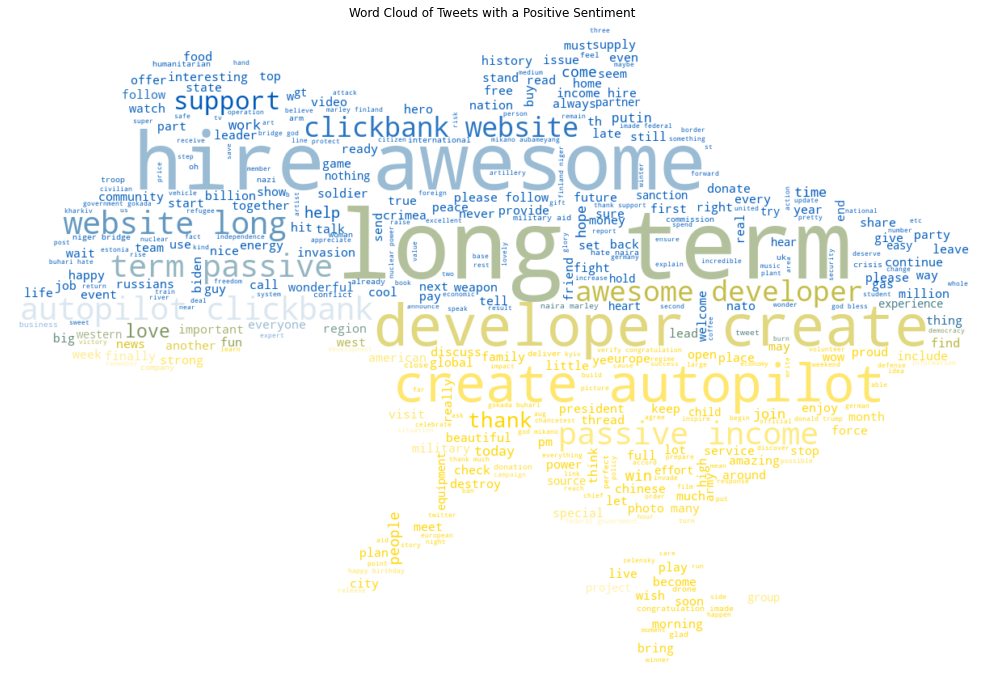

In [ ]:
text_cloud(p2_tweet_bool_pos, map_mask, 'Word Cloud of Tweets with a Positive Sentiment')

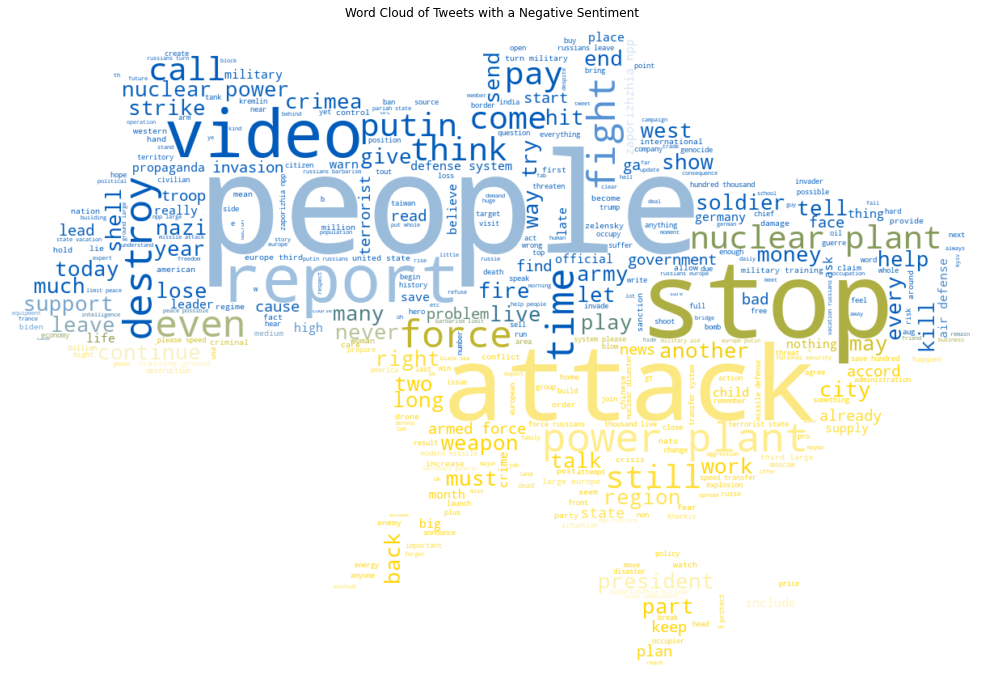

In [ ]:
text_cloud(p2_tweet_bool_neg, map_mask, 'Word Cloud of Tweets with a Negative Sentiment')

## 4.2 Reddit

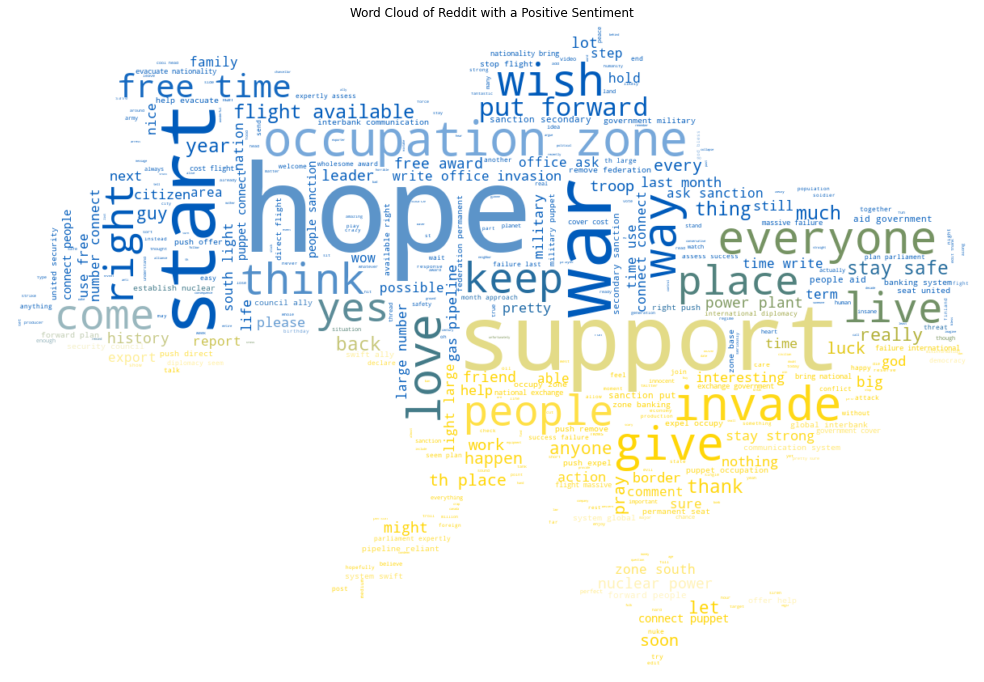

In [ ]:
text_cloud(p2_reddit_bool_pos, map_mask, 'Word Cloud of Reddit with a Positive Sentiment')

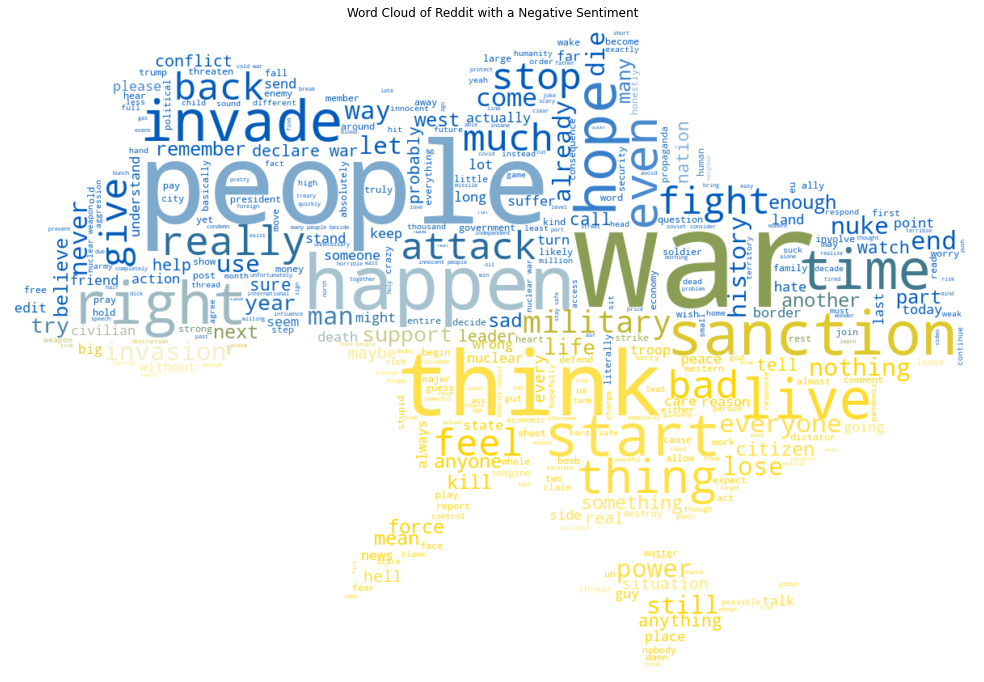

In [ ]:
text_cloud(p2_reddit_bool_neg, map_mask, 'Word Cloud of Reddit with a Negative Sentiment')